In [13]:
import os
import numpy as np
import librosa
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

# Directory paths
base_path = 'PhishingVoiceDataset'
phishing_path = os.path.join(base_path, 'Phishing')
non_phishing_path = os.path.join(base_path, 'NonPhishing')

# Function to extract features (MFCCs) from an audio file
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        return None 
    return mfccs_processed

# Data augmentation function (time stretching and pitch shifting)
def augment_audio(audio, sample_rate):
    audio_time_stretch = librosa.effects.time_stretch(audio, rate=np.random.uniform(0.9, 1.1))  
    audio_pitch_shift = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=np.random.randint(-2, 3))  
    return audio_time_stretch, audio_pitch_shift

# Parse files, extract features, and apply data augmentation
features = []
labels = []

for folder, label in [(phishing_path, 1), (non_phishing_path, 0)]:
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if file_path.endswith('.mp3'):
            audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
            mfccs = extract_features(file_path)
            if mfccs is not None:
                features.append(mfccs)
                labels.append(label)
                
                # Apply Data Augmentation
                augmented_time_stretch, augmented_pitch_shift = augment_audio(audio, sample_rate)
                mfccs_aug_time = np.mean(librosa.feature.mfcc(y=augmented_time_stretch, sr=sample_rate, n_mfcc=40).T, axis=0)
                mfccs_aug_pitch = np.mean(librosa.feature.mfcc(y=augmented_pitch_shift, sr=sample_rate, n_mfcc=40).T, axis=0)
                
                # Append augmented data
                features.append(mfccs_aug_time)
                labels.append(label)
                features.append(mfccs_aug_pitch)
                labels.append(label)

# Convert into Numpy arrays
features = np.array(features)
labels = np.array(labels)

# Feature scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Model Selection: Gradient Boosting Classifier with Grid Search for Hyperparameter Optimization
model = GradientBoostingClassifier(random_state=0, max_depth=4, min_samples_split=20, min_samples_leaf=10, validation_fraction=0.1, n_iter_no_change=10, tol=0.01)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.05]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Cross-validation setup using KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Train and evaluate the model using KFold Cross-Validation
best_model = None
best_score = 0
for train_idx, test_idx in kfold.split(features_scaled):
    X_train, X_test = features_scaled[train_idx], features_scaled[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # Fit the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Evaluate the model
    predictions = grid_search.predict(X_test)
    score = grid_search.score(X_test, y_test)
    
    print(classification_report(y_test, predictions))
    
    # Save the best performing model
    if score > best_score:
        best_score = score
        best_model = grid_search.best_estimator_

# Save the best model to disk
joblib.dump(best_model, 'phishing_detection_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print(f"Best model accuracy: {best_score}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        22
           1       0.81      0.85      0.83        26

    accuracy                           0.81        48
   macro avg       0.81      0.81      0.81        48
weighted avg       0.81      0.81      0.81        48

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.72      0.75      0.73        24
           1       0.74      0.71      0.72        24

    accuracy                           0.73        48
   macro avg       0.73      0.73      0.73        48
weighted avg       0.73      0.73      0.73        48

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'learning_rate': 0.01, 'n_

In [14]:
# Load the saved model and scaler
loaded_model = joblib.load('phishing_detection_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Function to extract features (MFCCs) from an audio file
def extract_features(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_path)
        return None 
    return mfccs_processed

# Function to predict on a new file
def predict_phishing(file_path, model, scaler):
    # Extract MFCCs from the audio file
    features = extract_features(file_path)
    
    # Check if feature extraction was successful
    if features is not None:
        # Scale the features using the loaded scaler
        features_scaled = scaler.transform([features])
        
        # Make the prediction (0 = Non-Phishing, 1 = Phishing)
        prediction = model.predict(features_scaled)
        proba = model.predict_proba(features_scaled)
        
        return prediction[0], proba
    else:
        return None, None

# Directory paths for test files
test_folder_path = 'mnt'

# Iterate over all files in the test folder and predict
results = []

for root, dirs, files in os.walk(test_folder_path):
    for file in files:
        if file.endswith('.mp3'):  # Ensure only MP3 files are processed
            file_path = os.path.join(root, file)
            prediction, proba = predict_phishing(file_path, loaded_model, loaded_scaler)
            
            if prediction is not None:
                if prediction == 1:
                    result = f"File: {file} is predicted as Phishing with probability {proba[0][1]:.2f}"
                else:
                    result = f"File: {file} is predicted as Non-Phishing with probability {proba[0][0]:.2f}"
                
                print(result)  # Print each result to the console
                results.append(result)
            else:
                print(f"Failed to extract features from {file}")

# Save the results to a file
with open('phishing_detection_results.txt', 'w') as f:
    for result in results:
        f.write(result + '\n')

print("Bulk prediction completed. Results saved to phishing_detection_results.txt")


File: n1.mp3 is predicted as Non-Phishing with probability 0.51
File: n2.mp3 is predicted as Non-Phishing with probability 0.64
File: n3.mp3 is predicted as Non-Phishing with probability 0.80
File: n4.mp3 is predicted as Non-Phishing with probability 0.69
File: n5.mp3 is predicted as Non-Phishing with probability 0.68
File: p1.mp3 is predicted as Phishing with probability 0.83
File: p2.mp3 is predicted as Phishing with probability 0.52
File: p3.mp3 is predicted as Phishing with probability 0.86
File: p4.mp3 is predicted as Non-Phishing with probability 0.86
File: p5.mp3 is predicted as Phishing with probability 0.55
Bulk prediction completed. Results saved to phishing_detection_results.txt


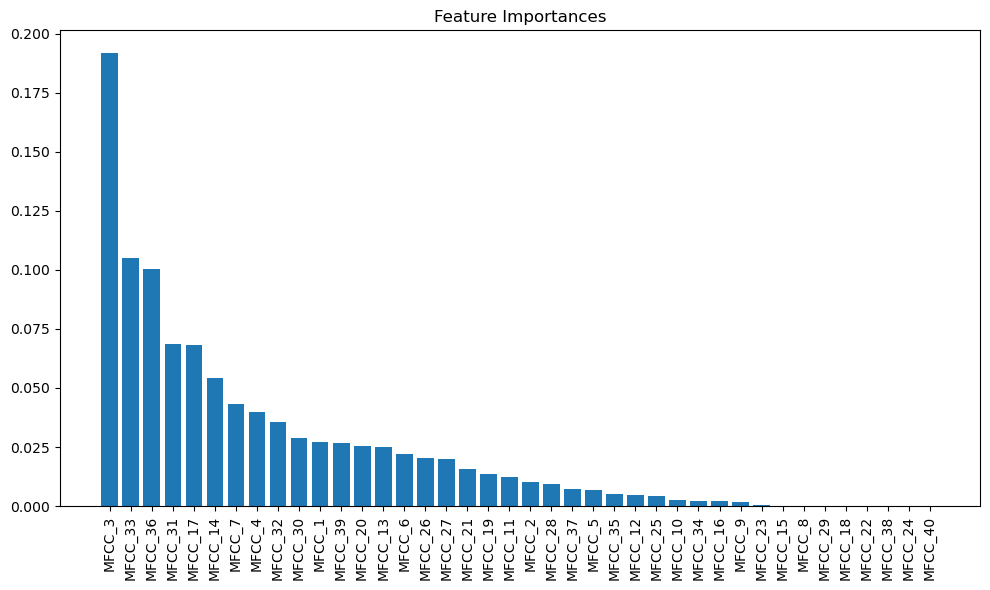

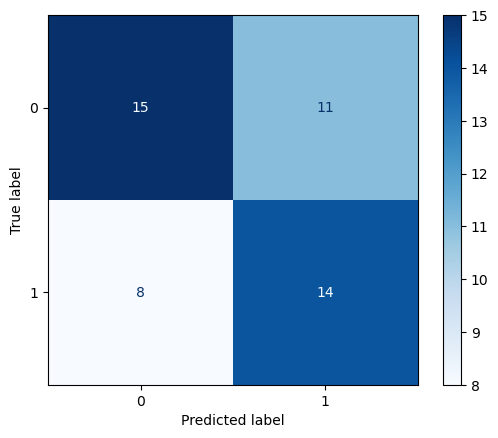

c:\Users\lahir\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lahir\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lahir\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lahir\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py", line 665, in fit
    y = self._encode_y(y=

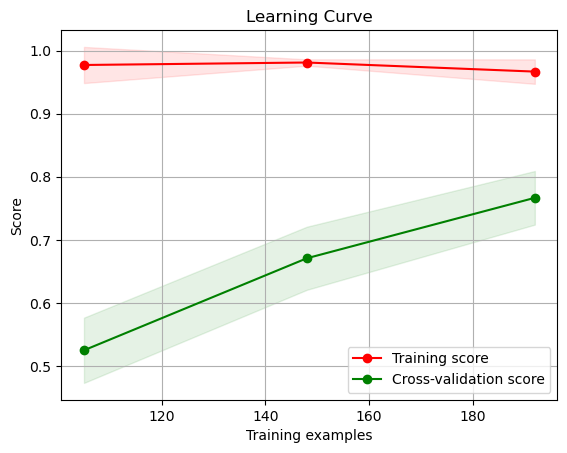

In [15]:
# Function to plot feature importance
def plot_feature_importance(model, feature_names):
    feature_import = model.feature_importances_
    indices = np.argsort(feature_import)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), feature_import[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Plot feature importance (assuming MFCCs are the features)
plot_feature_importance(best_model, [f'MFCC_{i+1}' for i in range(features_scaled.shape[1])])

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Generate a confusion matrix for the last fold
plot_confusion_matrix(y_test, predictions)

# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title='Learning Curve', ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.legend(loc='best')
    return plt

# Plot learning curve
plot_learning_curve(best_model, features_scaled, labels, cv=kfold, n_jobs=-1)

plt.show()
